In [21]:
#Challenge 1
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 100)


df0504=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df0511=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')
df0518=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190518.txt')
df0525=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190525.txt')
dfinitial=pd.concat([df0504,df0511,df0518,df0525]).reset_index(drop=True)


In [136]:
df=dfinitial
for col in df.columns:
    df = df.rename(columns={col: col.rstrip()})

In [137]:
#Challenge 2, plus other date stuff for later challenges
df=df[df['TIME'].str.contains('00:00')]
df['DATETIME']=df['DATE']+' '+df['TIME']
df['DATETIME']=pd.to_datetime(df['DATETIME'])
df['DATE']=pd.to_datetime(df['DATE'])
df['TIME']=pd.to_datetime(df['TIME'],format= '%H:%M:%S' ).dt.time
df['WEEK OF YEAR']=df['DATETIME'].dt.weekofyear
df['DAY OF WEEK']=df['DATETIME'].dt.dayofweek.astype('int')
df['WEEKEND']=(df['DAY OF WEEK']==5)|(df['DAY OF WEEK']==6)

In [138]:
dfhour=df.copy()
dfdaily=df.copy()

In [139]:
#Challenge 3
#df=df[df['TIME']=='00:00:00'] not all turnstiles will have a midnight entry
dfdaily=dfdaily.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False).first()
dfdaily.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION","DATE"], inplace=True)
dfdaily['NET ENTRIES']=abs(dfdaily.groupby(['C/A','UNIT','SCP','STATION'])['ENTRIES'].diff(-1)*-1)
dfdaily['NET EXITS']=abs(dfdaily.groupby(["C/A", "UNIT", "SCP", "STATION"])['EXITS'].diff(-1)*-1)
dfdaily['DAYS DIFF']=dfdaily.groupby(["C/A", "UNIT", "SCP", "STATION"])['DATE'].diff(-1)*-1
dfdaily=dfdaily[dfdaily['NET ENTRIES']<50000]
dfdaily.head()
dfdaily['DAYS DIFF'].value_counts()
dfdaily['DAYS DIFF']=dfdaily['DAYS DIFF'].dt.days
dfdaily['NET ENTRIES']=dfdaily['NET ENTRIES']//dfdaily['DAYS DIFF']
dfdaily['NET EXITS']=dfdaily['NET EXITS']//dfdaily['DAYS DIFF']
dfdaily['NET MOVEMENT']=dfdaily['NET ENTRIES']+dfdaily['NET EXITS']
dfdaily.dropna(inplace=True)

#Optimization- deal with resetting counters in a better way

In [140]:
dfdaily['NET ENTRIES'].sort_values()

124462        0.0
74542         0.0
74541         0.0
74540         0.0
74539         0.0
           ...   
92154     26076.0
26689     28517.0
10194     34006.0
26675     38364.0
16602     43080.0
Name: NET ENTRIES, Length: 119899, dtype: float64

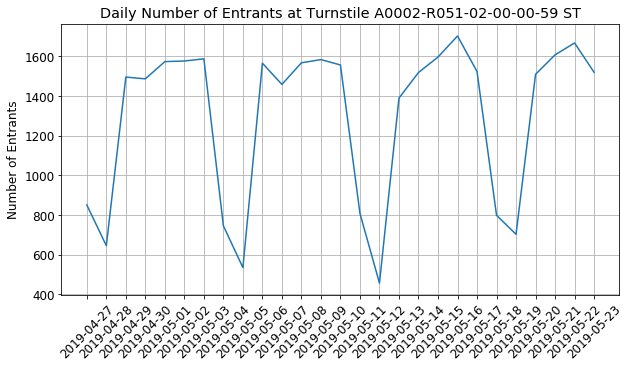

In [141]:
#Challenge 4
logic=(dfdaily['C/A']=='A002')&(dfdaily['UNIT']=='R051')&(dfdaily['SCP']=='02-00-00')&(dfdaily['STATION']=='59 ST')
dfsingleturn=dfdaily[logic]
plt.figure(figsize=[10,5])
plt.plot(dfsingleturn['DATETIME'],dfsingleturn['NET ENTRIES'])
plt.xticks(dfsingleturn['DATETIME'],rotation=45);
plt.ylabel('Number of Entrants')
plt.grid()
plt.title('Daily Number of Entrants at Turnstile A0002-R051-02-00-00-59 ST');

In [142]:
#Challenge 5
dfdaily.groupby(['C/A','UNIT','STATION','DATE'])['NET ENTRIES'].sum()

C/A    UNIT  STATION        DATE      
A002   R051  59 ST          2019-04-27     8394.0
                            2019-04-28     6337.0
                            2019-04-29    13132.0
                            2019-04-30    13664.0
                            2019-05-01    13748.0
                                           ...   
TRAM2  R469  RIT-ROOSEVELT  2019-05-19     3944.0
                            2019-05-20     3362.0
                            2019-05-21     3364.0
                            2019-05-22     3370.0
                            2019-05-23     2845.0
Name: NET ENTRIES, Length: 19299, dtype: float64

In [143]:
#Challenge 6
dfstatday=dfdaily.groupby(['STATION','DATE','WEEK OF YEAR','DAY OF WEEK'])['NET ENTRIES'].sum()
dfstatday=dfstatday.reset_index()
dfstatday.loc[dfstatday['DATE']=='2019-05-24','NET ENTRIES']=np.NaN

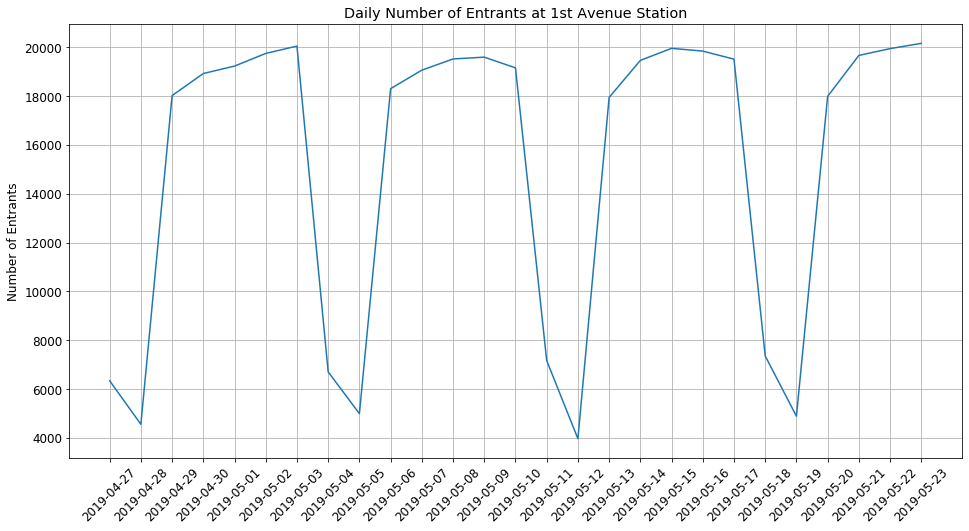

In [144]:
#Challenge 7
dffirstavstat=dfstatday[dfstatday['STATION']=='1 AV']
dffirstavstat=dffirstavstat.reset_index(drop=True)
plt.figure(figsize=[16,8])
plt.plot(dffirstavstat['DATE'],dffirstavstat['NET ENTRIES'])
plt.xticks(dffirstavstat['DATE'],rotation=45);
plt.ylabel('Number of Entrants')
plt.grid()
plt.title('Daily Number of Entrants at 1st Avenue Station');

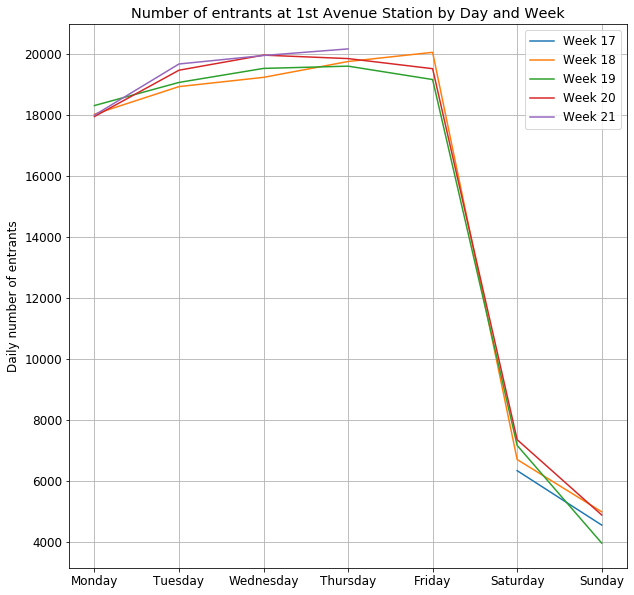

In [145]:
#dffirstavstat.loc[dfstatday['WEEK OF YEAR']==17,'NET ENTRIES']
#Challenge 8
plt.figure(figsize=[10,10])
for week in dffirstavstat['WEEK OF YEAR'].unique():
    x=dffirstavstat.loc[dffirstavstat['WEEK OF YEAR']==week,'DAY OF WEEK']
    y=dffirstavstat.loc[dffirstavstat['WEEK OF YEAR']==week,'NET ENTRIES']
    plt.plot(x,y,label='Week '+str(week))
plt.legend()
daysofweek=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.xticks(sorted(dffirstavstat['DAY OF WEEK'].unique()),daysofweek)
plt.ylabel('Daily number of entrants')
plt.title('Number of entrants at 1st Avenue Station by Day and Week');
plt.grid()

In [146]:
#Challenge 9
dfdaily.groupby('STATION')['NET ENTRIES'].sum().sort_values(ascending=False)
#Outliers are usually due to the entries counter being reset or missing data

STATION
34 ST-PENN STA     4036959.0
GRD CNTRL-42 ST    3494749.0
34 ST-HERALD SQ    2992667.0
23 ST              2766903.0
42 ST-PORT AUTH    2556219.0
                     ...    
NEWARK HM HE           635.0
EXCHANGE PLACE         449.0
CITY / BUS             188.0
14TH STREET            164.0
ORCHARD BEACH            5.0
Name: NET ENTRIES, Length: 364, dtype: float64

In [147]:
#Challenge 9, corrected for outliers

totaldf=dfdaily.groupby(['STATION','DATE'])['NET ENTRIES'].sum().reset_index()
totaldf=totaldf.groupby('STATION')['NET ENTRIES'].mean().sort_values(ascending=False).reset_index()
totaldf['NET ENTRIES']=totaldf['NET ENTRIES'].astype('int')
top10daily=totaldf.head(10)
print(top10daily)
topstations=list(top10daily['STATION'])

           STATION  NET ENTRIES
0   34 ST-PENN STA       149517
1  GRD CNTRL-42 ST       129435
2  34 ST-HERALD SQ       110839
3            23 ST       102477
4  42 ST-PORT AUTH        94674
5   14 ST-UNION SQ        93890
6   TIMES SQ-42 ST        92523
7        FULTON ST        83944
8            86 ST        77922
9           125 ST        73212


In [148]:
#hourly counts are not cute
counts=dfhour['TIME'].value_counts()
counts[counts>100]

00:00:00    69096
04:00:00    69092
08:00:00    69075
16:00:00    69061
12:00:00    69049
20:00:00    68972
21:00:00    50879
09:00:00    50873
17:00:00    50866
05:00:00    50853
13:00:00    50833
01:00:00    50828
18:00:00     3137
22:00:00     3136
10:00:00     3132
02:00:00     3131
06:00:00     3128
14:00:00     3125
19:00:00     1076
15:00:00     1076
07:00:00     1074
11:00:00     1073
03:00:00     1066
23:00:00     1064
Name: TIME, dtype: int64

In [149]:
dfhourtop=dfhour[dfhour['STATION'].isin(topstations)]
topcounts=dfhourtop['TIME'].value_counts()
topcounts=topcounts[topcounts>100]
print(topcounts)

08:00:00    9939
04:00:00    9936
00:00:00    9935
16:00:00    9933
12:00:00    9925
20:00:00    9905
21:00:00    5424
17:00:00    5420
09:00:00    5418
13:00:00    5414
05:00:00    5411
01:00:00    5405
06:00:00    1176
02:00:00    1176
22:00:00    1176
18:00:00    1176
14:00:00    1175
10:00:00    1174
15:00:00    1075
19:00:00    1075
11:00:00    1073
07:00:00    1073
03:00:00    1066
23:00:00    1063
Name: TIME, dtype: int64


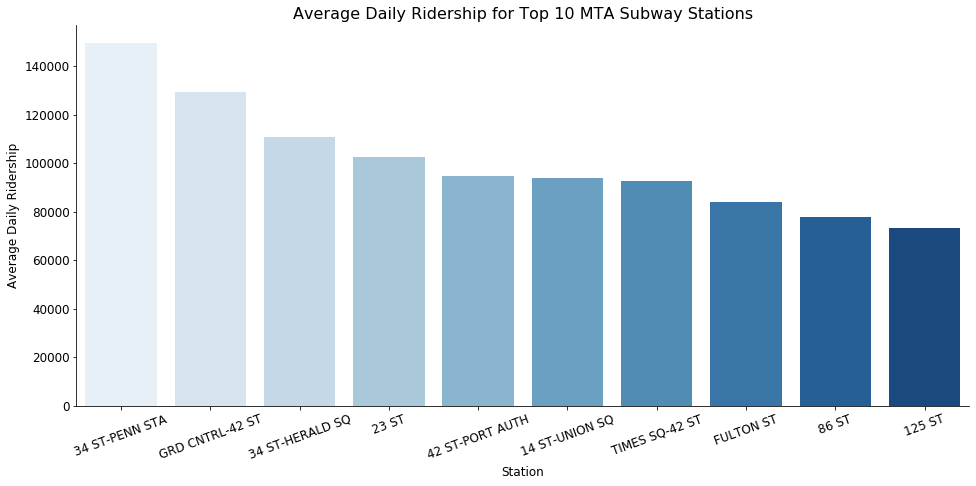

In [150]:
import seaborn as sns
plt.figure(figsize=[16,7])
font={'size':12}
plt.rc('font', **font) 
sns.barplot(x ='STATION',y='NET ENTRIES',data=top10daily,palette=sns.color_palette("Blues",10));
plt.xticks(rotation=20);
plt.xlabel('Station')
plt.ylabel('Average Daily Ridership')
plt.title('Average Daily Ridership for Top 10 MTA Subway Stations',size=16)
sns.despine()

In [191]:
#Average Weekend vs Weekday Ridership per day
#dfdaily.head()

In [152]:
weekend_df = dfdaily[dfdaily["WEEKEND"]]
week_df = dfdaily[dfdaily["WEEKEND"] == False]

In [153]:
totaldf_weekend=weekend_df.groupby(['STATION','DATE'])['NET ENTRIES'].sum().reset_index()
totaldf_weekend=totaldf_weekend.groupby('STATION')['NET ENTRIES'].mean().sort_values(ascending=False).reset_index()
totaldf_weekend['NET ENTRIES']=totaldf_weekend['NET ENTRIES'].astype('int')
totaldf_weekend["TIME"]='Weekend Average'
top10weekend=totaldf_weekend.head(10)
print(top10weekend)
topstations=list(top10weekend['STATION'])

           STATION  NET ENTRIES             TIME
0   34 ST-PENN STA        86555  Weekend Average
1  34 ST-HERALD SQ        67555  Weekend Average
2  42 ST-PORT AUTH        64135  Weekend Average
3   14 ST-UNION SQ        61352  Weekend Average
4   TIMES SQ-42 ST        59262  Weekend Average
5            23 ST        53452  Weekend Average
6  GRD CNTRL-42 ST        52821  Weekend Average
7           125 ST        48900  Weekend Average
8            86 ST        45938  Weekend Average
9         CANAL ST        45363  Weekend Average


In [154]:
totaldf_week=week_df.groupby(['STATION','DATE'])['NET ENTRIES'].sum().reset_index()
totaldf_week=totaldf_week.groupby('STATION')['NET ENTRIES'].mean().sort_values(ascending=False).reset_index()
totaldf_week['NET ENTRIES']=totaldf_week['NET ENTRIES'].astype('int')
totaldf_week["TIME"]='Weekday Average'
top10week=totaldf_week.head(10)
print(top10week)
topstations_week=list(top10week['STATION'])

           STATION  NET ENTRIES             TIME
0   34 ST-PENN STA       176027  Weekday Average
1  GRD CNTRL-42 ST       161693  Weekday Average
2  34 ST-HERALD SQ       129064  Weekday Average
3            23 ST       123120  Weekday Average
4   14 ST-UNION SQ       107590  Weekday Average
5  42 ST-PORT AUTH       107533  Weekday Average
6   TIMES SQ-42 ST       106528  Weekday Average
7        FULTON ST       104091  Weekday Average
8            86 ST        91389  Weekday Average
9           125 ST        83449  Weekday Average


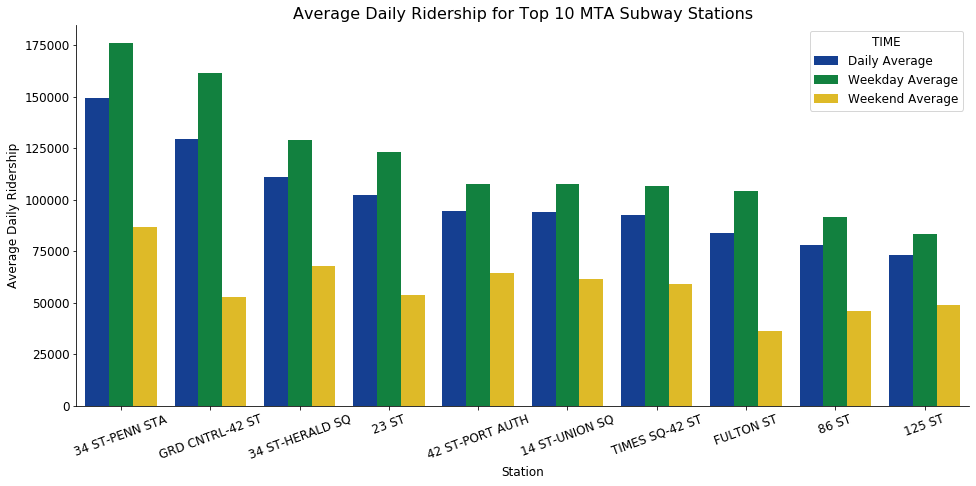

In [155]:
data = totaldf.copy()
data["TIME"]='Daily Average'
data = pd.concat([data,totaldf_week,totaldf_weekend])
data = data[data['STATION'].isin(top10daily['STATION'])]
plt.figure(figsize=[16,7])
font={'size':12}
plt.rc('font', **font) 
sns.barplot(x ='STATION',y='NET ENTRIES',hue = 'TIME',data=data,palette=sns.color_palette(["#0039A6","#00933C","#FCCC0A"])); #,palette=sns.color_palette("Blues",4)
# sns.barplot(x ='STATION',y='NET ENTRIES',data=data.head(10),palette=sns.color_palette("Blues",10));
# sns.barplot(x ='STATION',y='weekend',data=data.head(10),palette=sns.color_palette("Reds",10));
# sns.barplot(x ='STATION',y='week',data=data.head(10),palette=sns.color_palette("Greens",10));

plt.xticks(rotation=20);
plt.xlabel('Station')
plt.ylabel('Average Daily Ridership')
plt.title('Average Daily Ridership for Top 10 MTA Subway Stations',size=16)
sns.despine()

In [218]:
weekend_delta = totaldf.copy()
weekend_delta = weekend_delta.set_index('STATION')
weekend_delta = pd.concat([weekend_delta,
                  totaldf_weekend.set_index('STATION')['NET ENTRIES'],
                  totaldf_week.set_index('STATION')['NET ENTRIES']],
                 axis=1)
weekend_delta.columns=['DAILY', 'WEEKEND','WEEKDAY']
weekend_delta['WEEKEND DELTA'] = (weekend_delta['WEEKDAY'] - weekend_delta['WEEKEND'])/weekend_delta['DAILY']
weekend_delta['abs WEEKEND DELTA'] = np.abs(weekend_delta['WEEKEND DELTA'])
weekend_delta = weekend_delta.sort_values('abs WEEKEND DELTA', ascending = False)

# sns.distplot(data['WEEKEND DELTA'])
weekend_delta.head(50)


,DAILY,WEEKEND,WEEKDAY,WEEKEND DELTA,abs WEEKEND DELTA
EXCHANGE PLACE,224,449.0,0,-2.004464,2.004464
AQUEDUCT N.COND,684,9.0,968,1.402047,1.402047
AQUEDUCT RACETR,1236,78.0,1724,1.331715,1.331715
CYPRESS HILLS,1171,165.0,1594,1.220325,1.220325
75 ST-ELDERTS,2766,451.0,3740,1.189082,1.189082
85 ST-FOREST PK,2858,477.0,3861,1.184045,1.184045
BROAD CHANNEL,269,45.0,363,1.182156,1.182156
121 ST,2062,363.0,2777,1.170708,1.170708
HUNTERS PT AV,5474,1048.0,7338,1.149068,1.149068
104 ST,3985,785.0,5333,1.141280,1.141280


In [19]:
#Challenge 10
plt.hist(np.log10(totaldf),20);
plt.xlabel('Total number of entrants on a log10 scale')
plt.ylabel('Number of stations')
plt.title('Distribution of number of entrants for a station during 4 weeks in April/May');


TypeError: loop of ufunc does not support argument 0 of type str which has no callable log10 method

In [ ]:

#For missing dates, create a new diff column for number of days between row, then we can divide the net entries by
#the number of days
df.groupby(['C/A','UNIT','SCP','STATION','DATE'])['ENTRIES'].count().sort_values()

In [ ]:
df[(df['C/A']=='A038')&(df['UNIT']=='R085')&(df['SCP']=='00-06-00')]

In [ ]:
df[(df['C/A']=='N508')&(df['UNIT']=='R453')&(df['SCP']=='00-00-00')]['DATE'].value_counts()